# Transformer实现详解
## 自注意力机制实现

核心公式为：

\begin{equation}
Y = \mathrm{softmax}\left(\frac{KQ^T}{\sqrt{d}}\right)V
\end{equation}

实现通常基于输入$X$而非直接使用$K$、$Q$、$V$，完整运算包含输出权重矩阵：
\begin{equation}
Y = \left(\mathrm{softmax}\left(\frac{X W_K W_Q^T X^T}{\sqrt{d}}\right)X W_V \right) W_o.
\end{equation}
以下为具体实现：

In [1]:
# 库导入
import numpy as np
import torch
import torch.nn as nn

In [2]:
def softmax(Z):
    Z = np.exp(Z - Z.max(axis=-1, keepdims=True))  # 减去最大值防止数值溢出
    return Z / Z.sum(axis=-1, keepdims=True) 
    
def self_attention(X, mask, W_KQV, W_out):
    """
    参数：
        X: 输入矩阵 [序列长度, 特征维度]
        mask: 注意力掩码（用于遮挡未来信息）
        W_KQV: 组合的KQV权重矩阵 [d_model, 3*d_k]
        W_out: 输出权重矩阵 [d_v, d_model]
    返回：
        输出矩阵, 注意力权重
    """
    # 将输入投影到K,Q,V空间 [seq_len, 3*d_k]
    K, Q, V = np.split(X @ W_KQV, 3, axis=-1)
    
    # 计算缩放点积注意力分数 [seq_len, seq_len]
    attn_scores = K @ Q.swapaxes(-1, -2) / np.sqrt(X.shape[-1])
    
    # 应用掩码
    attn_weights = softmax(attn_scores + mask)
    
    # 应用注意力权重到V并输出 [seq_len, d_model]
    output = attn_weights @ V @ W_out
    
    return output, attn_weights

In [3]:
# 创建上三角掩码矩阵（用于防止信息泄漏）
T = 5  # 序列长度
M = torch.triu(-float("inf") * torch.ones(T, T), 1)  # 生成上三角无穷小矩阵
print("注意力掩码矩阵示例：")
print(M)

注意力掩码矩阵示例：
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


## PyTorch实现对比

与PyTorch的`nn.MultiheadAttention`进行对比验证：

In [4]:
# 参数配置
T, d = 100, 64  # 序列长度100，特征维度64
attn = nn.MultiheadAttention(d, 1, bias=False, batch_first=True)  # 单头注意力
M = torch.triu(-float("inf") * torch.ones(T, T), 1)  # 掩码矩阵
X = torch.randn(1, T, d)  # 输入数据 [batch_size, seq_len, d_model]

In [ ]:
# 使用自定义实现计算
Y, A = self_attention(
    X[0].numpy(),  # 输入数据
    M.numpy(),     # 掩码矩阵
    attn.in_proj_weight.detach().numpy().T,  # 合并的KQV权重
    attn.out_proj.weight.detach().numpy().T  # 输出权重
)

# 使用pytorch
Y_pytorch, A_pytorch = attn(X,  # Q
                            X,  # K
                            X,  # V
                            attn_mask = M)

# 对比
np.linalg.norm(Y-Y_pytorch[0].detach().numpy())

2.3307637e-06

In [7]:
Y.shape

(100, 64)

## 批处理矩阵乘法

当处理小批量数据时，需要批量矩阵乘法支持。numpy的`@`运算符天然支持高维数组的批处理：

In [8]:
# 批矩阵乘法示例
B = np.random.randn(10, 3, 5, 4)  # 10个3x5x4的批量
C = np.random.randn(10, 3, 4, 3)  # 10个3x4x3的批量
result = B @ C
print("批量矩阵乘法结果形状：", result.shape)  # 预期输出 (10,3,5,3)

批量矩阵乘法结果形状： (10, 3, 5, 3)


## 多头注意力机制

- 通过分割K/Q/V到多个子空间实现并行注意力模式学习：
\begin{equation}
Y = \begin{bmatrix} Y_1 & Y_2 & \cdots & Y_{\mathrm{heads}} \end{bmatrix} W_o.
\end{equation}


- 并行捕捉多类型依赖：不同头可关注不同模式（如语法、语义、指代等）

In [9]:
def multihead_attention(X, mask, heads, W_KQV, W_out):
    """
    多头注意力实现
    参数：
        X: 输入矩阵 [batch_size, seq_len, d_model]
        mask: 注意力掩码 [seq_len, seq_len]
        heads: 注意力头数量
        W_KQV: 组合的KQV权重矩阵 [d_model, 3*d_k]
        W_out: 输出权重矩阵 [d_v, d_model]
    返回：
        (输出矩阵, 注意力权重)
    """
    N, T, d = X.shape  # 输入形状：批大小N，序列长度T，特征维度d
    
    # 将输入投影到K,Q,V空间 [N, T, 3*d_k]
    K, Q, V = np.split(X @ W_KQV, 3, axis=-1)
    
    # K、Q、V 的形状均为 (N, heads, T, d_k)，表示每个头独立处理 d_k 维的子空间
    K = K.reshape(N, T, heads, d//heads).swapaxes(1, 2)
    Q = Q.reshape(N, T, heads, d//heads).swapaxes(1, 2)
    V = V.reshape(N, T, heads, d//heads).swapaxes(1, 2)
    
    # 计算缩放点积注意力 [N, heads, T, T]
    attn_scores = K @ Q.swapaxes(-1, -2) / np.sqrt(d//heads)
    attn_weights = softmax(attn_scores + mask)
    
    # 应用注意力权重 [N, heads, T, d_k]
    context = attn_weights @ V
    
    # 合并多头输出 [N, T, d_model]
    context = context.swapaxes(1, 2).reshape(N, T, d)
    
    # 应用输出权重矩阵
    return context @ W_out, attn_weights

## Transformer模块

完整Transformer模块包含：
1. 带残差连接的多头注意力
2. 层标准化
3. 前馈网络
4. 第二次残差连接和层标准化

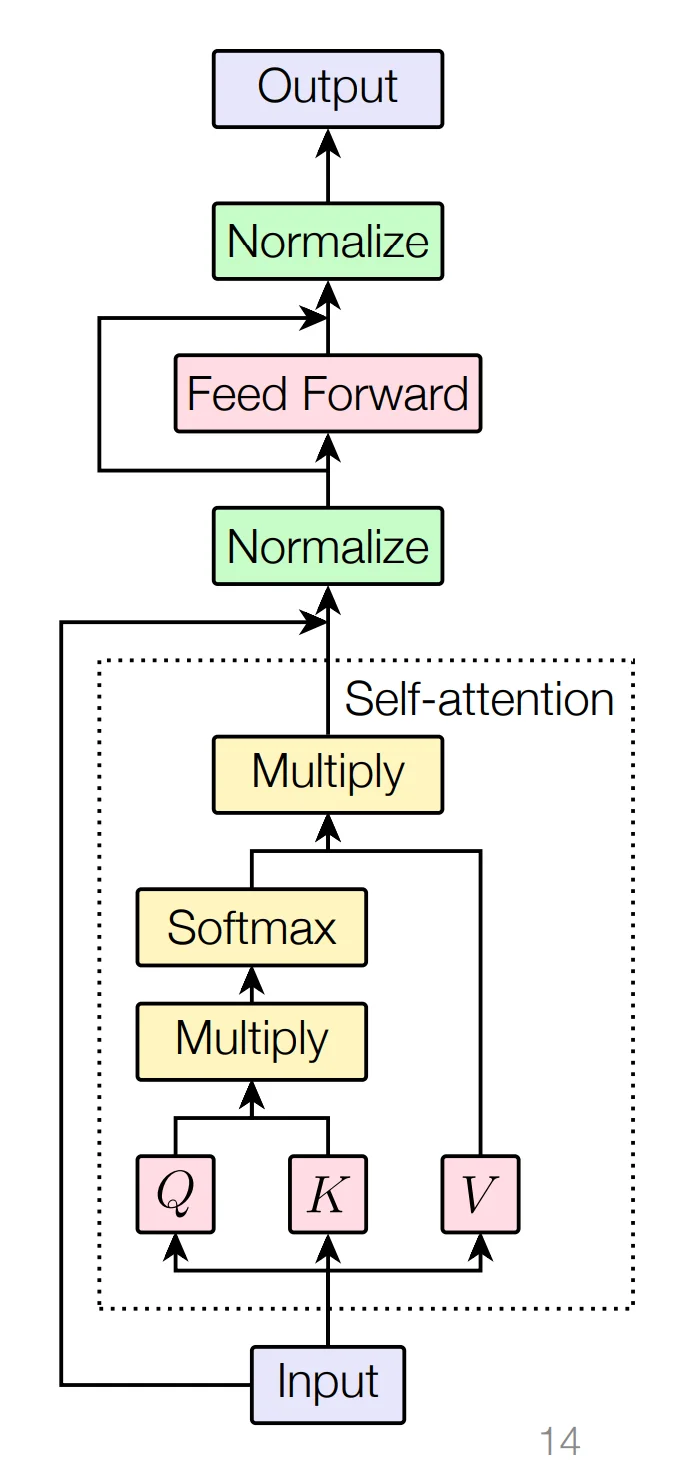

In [10]:
def layer_norm(Z, eps=1e-5):
    """层标准化实现
    参数：
        Z: 输入矩阵
        eps: 防止除零的小量
    返回：
        标准化后的矩阵
    """
    mean = Z.mean(axis=-1, keepdims=True)
    var = Z.var(axis=-1, keepdims=True)
    return (Z - mean) / np.sqrt(var + eps)

def relu(Z):
    return np.maximum(Z, 0)

def transformer(X, mask, heads, W_KQV, W_out, W_ff1, W_ff2, eps=1e-5):
    # 多头注意力+残差+层标准化
    attn_output, _ = multihead_attention(X, mask, heads, W_KQV, W_out)
    Z = layer_norm(attn_output + X, eps)
    
    # 前馈网络（两层层）
    ff_output = relu(Z @ W_ff1) @ W_ff2
    
    # 残差连接+层标准化
    return layer_norm(ff_output + Z, eps)

## Transformer效率优化探讨（仅列举）

当前Transformer的主要效率瓶颈在于$O(T^2d)$复杂度的注意力矩阵计算，主要优化方向包括：

1. **稀疏注意力**：通过限制注意力范围减少计算量
   - 局部窗口注意力（如Longformer）
   - 层次注意力（如BigBird）

2. **低秩近似**：利用矩阵分解技术
   - Linformer的键值低秩投影
   - Performer的随机特征映射

3. **内存优化**：
   - FlashAttention的IO感知算法
   - 混合精度训练

实际应用中需要权衡计算效率与模型表现，当前最有效的优化方案仍是结合稀疏注意力和内存优化技术。